/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/pacmap/pacmap.py:828: UserWarning: Warning: random state is set to 42
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


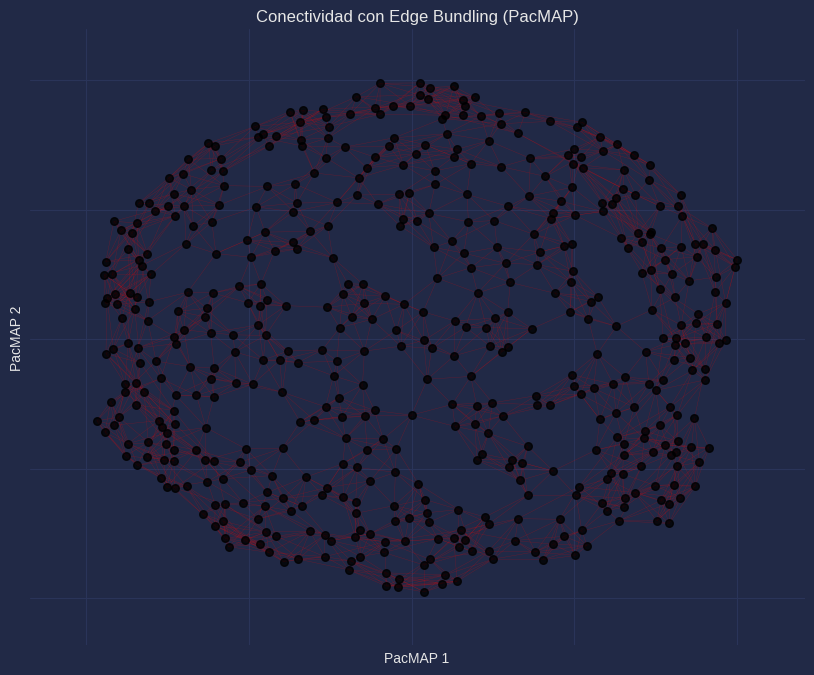

In [8]:
import numpy as np
import pacmap
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import mplcyberpunk  # Estilo visual mejorado
from sklearn.datasets import make_blobs
from scipy.spatial import KDTree
from networkx.drawing.layout import kamada_kawai_layout

# 🔹 Generar datos densos con blobs
X, _ = make_blobs(n_samples=500, centers=1, cluster_std=0.5, random_state=42)

# 🔹 Aplicar PacMAP para reducir a 2D
pacmap_reducer = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0, random_state=42)
X_pacmap = pacmap_reducer.fit_transform(X)

# 🔹 Construir grafo de conectividad con KDTree
tree = KDTree(X)  
neighbors = tree.query(X, k=8)[1]  # Obtener los 8 vecinos más cercanos

# 🔹 Crear el grafo en NetworkX
G = nx.Graph()
for i in range(len(X)):
    for j in neighbors[i][1:]:  # Evitar conectar un nodo consigo mismo
        G.add_edge(i, j)

# 🔹 Aplicar Force-Directed Edge Bundling con Kamada-Kawai layout
pos = {i: X_pacmap[i] for i in range(len(X))}
pos_bundle = kamada_kawai_layout(G, pos=pos)  # Edge Bundling

# 🔹 Graficar con mejor estilo
plt.style.use("cyberpunk")  # Activar el estilo cyberpunk
fig, ax = plt.subplots(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos_bundle, node_size=30, node_color='black', alpha=0.8)
nx.draw_networkx_edges(G, pos_bundle, width=0.3, edge_color="red", alpha=0.3)

# 🔹 Efectos visuales
for spine in ax.spines.values():
    spine.set_visible(False)
plt.title("Conectividad con Edge Bundling (PacMAP)")
plt.xlabel("PacMAP 1")
plt.ylabel("PacMAP 2")
plt.show()


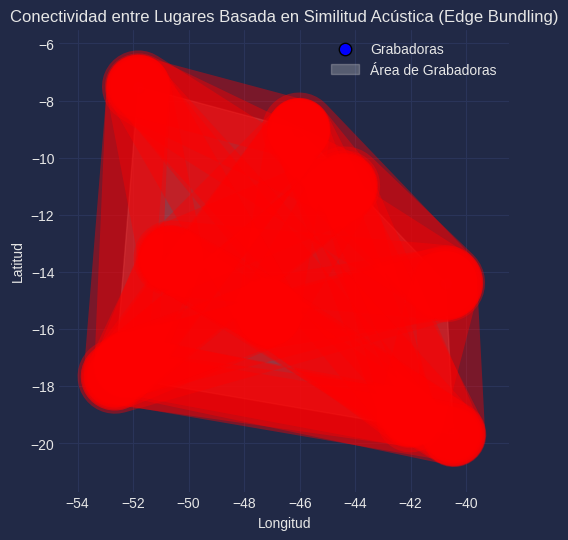

In [24]:
import numpy as np
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph
from scipy.spatial import ConvexHull

# 🔹 Simulación de coordenadas de grabadoras en Sudamérica
np.random.seed(42)
n_grabadoras = 10
n_audios = 2000  # 🔥 Ahora usamos 2000 muestras

# Coordenadas aleatorias de grabadoras en Sudamérica (Brasil - Argentina)
coordenadas_grabadoras = {
    i: (np.random.uniform(-20, -5), np.random.uniform(-55, -40))  # Latitud y longitud
    for i in range(n_grabadoras)
}

# 🔹 Asignar audios a grabadoras
grabadora_id = np.random.choice(list(coordenadas_grabadoras.keys()), size=n_audios)

# 🔹 Generar datos ficticios de espectrogramas (128 dimensiones)
X_audio = np.random.rand(n_audios, 128)

# 🔹 Construcción de grafo de conectividad entre audios
audio_graph = kneighbors_graph(X_audio, n_neighbors=15, mode="connectivity", include_self=False)
G_audio = nx.from_scipy_sparse_array(audio_graph)

# 🔹 Construcción de grafo de conectividad entre grabadoras
G_places = nx.Graph()
for i in range(n_grabadoras):
    G_places.add_node(i, pos=coordenadas_grabadoras[i])  # Añadir nodos con ubicación geográfica

# 🔹 Conectar grabadoras si tienen audios similares
for i, j in G_audio.edges():
    g1, g2 = grabadora_id[i], grabadora_id[j]
    if g1 != g2:  # Solo conectamos si son grabadoras diferentes
        if G_places.has_edge(g1, g2):
            G_places[g1][g2]["weight"] += 1
        else:
            G_places.add_edge(g1, g2, weight=1)

# 🔹 Convertir nodos a GeoDataFrame
grabadoras_gdf = gpd.GeoDataFrame(
    {"id": list(G_places.nodes())},
    geometry=gpd.points_from_xy(
        [coordenadas_grabadoras[i][1] for i in G_places.nodes()],  # Longitud
        [coordenadas_grabadoras[i][0] for i in G_places.nodes()]   # Latitud
    ),
    crs="EPSG:4326"
)

# 🔹 Transformar posiciones del grafo para Geopandas
pos_geo = {i: (grabadoras_gdf.geometry.x.iloc[i], grabadoras_gdf.geometry.y.iloc[i]) for i in G_places.nodes()}

# 🔹 Aplicar Edge Bundling para reducir el cruce de líneas
def edge_bundle(G, pos, alpha=0.3, segments=10):
    """ Suaviza las conexiones entre nodos con Edge Bundling """
    new_edges = []
    for u, v, data in G.edges(data=True):
        x1, y1 = pos[u]
        x2, y2 = pos[v]
        
        # 🔹 Generamos puntos intermedios para suavizar la curva
        x = np.linspace(x1, x2, segments)
        y = np.linspace(y1, y2, segments)
        
        # 🔹 Ajustamos el peso para que las líneas sean más delgadas
        weight = max(0.2, data["weight"] * 0.1)  
        
        new_edges.append((x, y, weight))
    
    return new_edges

# 🔹 Obtener las curvas de edge bundling
bundled_edges = edge_bundle(G_places, pos_geo, alpha=0.3, segments=20)

# 🔹 Graficar el grafo con Edge Bundling
fig, ax = plt.subplots(figsize=(10, 6))

# 🔹 Dibujar conexiones suavizadas
for x, y, weight in bundled_edges:
    ax.plot(x, y, color="red", linewidth=weight, alpha=0.4)

# 🔹 Dibujar nodos (grabadoras)
grabadoras_gdf.plot(ax=ax, color="blue", markersize=80, edgecolor="black", label="Grabadoras")

# 🔹 Dibujar Convex Hull para resaltar el área ocupada por las grabadoras
points = np.array([pos_geo[i] for i in G_places.nodes()])
hull = ConvexHull(points)
hull_path = points[hull.vertices]
ax.fill(hull_path[:, 0], hull_path[:, 1], color="lightgray", alpha=0.3, label="Área de Grabadoras")

# 🔹 Ajustar los límites del gráfico
ax.set_xlim(grabadoras_gdf.geometry.x.min() - 2, grabadoras_gdf.geometry.x.max() + 2)
ax.set_ylim(grabadoras_gdf.geometry.y.min() - 2, grabadoras_gdf.geometry.y.max() + 2)

# 🔹 Ajustes finales
plt.title("Conectividad entre Lugares Basada en Similitud Acústica (Edge Bundling)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend()
plt.grid(True)
plt.show()





In [30]:
X_audio.shape

(20, 512)

In [40]:
Line

NameError: name 'Line' is not defined

In [43]:
line


NameError: name 'line' is not defined

In [65]:
df['grabadora'][i]

1

In [70]:
G_audio.edges()

EdgeView([])

Nodos en G_audio: 1000, Aristas en G_audio: 49500


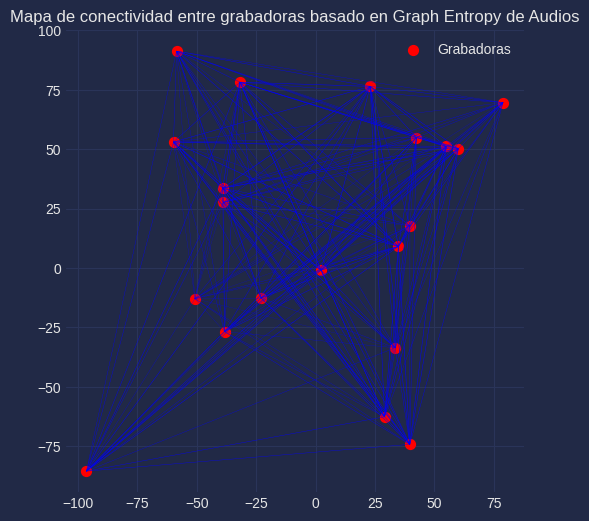

In [87]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from scipy.stats import entropy
from shapely.geometry import Point, LineString

# 1️⃣ Simulación de datos: DataFrame con 1000 audios
np.random.seed(42)
n_audios = 1000
n_features = 512
n_grabadoras = 20

grabadoras = np.random.randint(0, n_grabadoras, n_audios)  # Asignar cada audio a una grabadora
X_audio = np.random.rand(n_audios, n_features)  # Simular características de audio

# Crear DataFrame
df = pd.DataFrame(X_audio, columns=[f'feat_{i}' for i in range(n_features)])
df['grabadora'] = grabadoras

# 2️⃣ Calcular la matriz de distancia/similitud entre audios
distance_matrix = squareform(pdist(X_audio, metric="euclidean"))
sim_matrix = np.exp(-distance_matrix / np.std(distance_matrix))  # Normalizar mejor la similitud

# 3️⃣ Calcular la entropía de cada audio
node_entropy = np.array([entropy(sim_matrix[i] + 1e-10) for i in range(n_audios)])  # Evitar log(0)

# 4️⃣ Definir umbral de similitud para conexiones entre audios
threshold = np.percentile(sim_matrix, 90)  # Usar percentil sobre sim_matrix en lugar de entropía
connectivity_matrix = sim_matrix >= threshold  # Conectar audios con alta similitud

# 5️⃣ Crear grafo de conectividad de audios
G_audio = nx.Graph()
for i in range(n_audios):
    G_audio.add_node(i, grabadora=df['grabadora'][i])
    for j in range(i + 1, n_audios):
        if connectivity_matrix[i, j]:
            G_audio.add_edge(i, j)

# Verificar si el grafo tiene nodos y conexiones
print(f"Nodos en G_audio: {G_audio.number_of_nodes()}, Aristas en G_audio: {G_audio.number_of_edges()}")

# 6️⃣ Construir conectividad entre grabadoras a partir del grafo de audios
G_grabadoras = nx.Graph()
for i, j in G_audio.edges():
    grabadora_i = df['grabadora'][i]
    grabadora_j = df['grabadora'][j]
    if grabadora_i != grabadora_j:
        if G_grabadoras.has_edge(grabadora_i, grabadora_j):
            G_grabadoras[grabadora_i][grabadora_j]['weight'] += 1
        else:
            G_grabadoras.add_edge(grabadora_i, grabadora_j, weight=1)

# 7️⃣ Simulación de coordenadas de grabadoras para visualización
coordenadas = {i: Point(np.random.uniform(-100, 100), np.random.uniform(-100, 100)) for i in range(n_grabadoras)}
geo_df = gpd.GeoDataFrame({"grabadora": list(coordenadas.keys()), "geometry": list(coordenadas.values())})

# 8️⃣ Visualización del mapa de conectividad entre grabadoras
fig, ax = plt.subplots(figsize=(10, 6))
geo_df.plot(ax=ax, color='red', markersize=50, label="Grabadoras")

# Dibujar conexiones entre grabadoras
for i, j in G_grabadoras.edges():
    if i in coordenadas and j in coordenadas:
        line = LineString([coordenadas[i], coordenadas[j]])
        gpd.GeoSeries([line]).plot(ax=ax, color='blue', linewidth=G_grabadoras[i][j]['weight'] * 0.001)

ax.set_title("Mapa de conectividad entre grabadoras basado en Graph Entropy de Audios")
plt.legend()
plt.show()



In [85]:
sim_matrix

array([[1.00000000e+00, 2.23597056e-11, 2.63173654e-11, ...,
        8.56760344e-12, 1.46485611e-11, 2.84499377e-11],
       [2.23597056e-11, 1.00000000e+00, 5.89679070e-11, ...,
        2.55305290e-11, 1.11216271e-10, 4.18212391e-11],
       [2.63173654e-11, 5.89679070e-11, 1.00000000e+00, ...,
        1.12319852e-11, 3.66025848e-11, 3.01670633e-11],
       ...,
       [8.56760344e-12, 2.55305290e-11, 1.12319852e-11, ...,
        1.00000000e+00, 4.28714299e-11, 1.53766600e-11],
       [1.46485611e-11, 1.11216271e-10, 3.66025848e-11, ...,
        4.28714299e-11, 1.00000000e+00, 2.79851953e-11],
       [2.84499377e-11, 4.18212391e-11, 3.01670633e-11, ...,
        1.53766600e-11, 2.79851953e-11, 1.00000000e+00]])